### Import Libraries

This cell imports all the necessary Python libraries for data manipulation, machine learning model building, evaluation, calibration, and explainability:

*   **`pandas` and `numpy`**: Fundamental libraries for data handling and numerical operations.
*   **`lightgbm`**: Used for building the LightGBM classifier, a gradient boosting framework.
*   **`sklearn.model_selection.train_test_split`**: For splitting data into training and testing sets.
*   **`sklearn.metrics`**: Contains various metrics for model evaluation, such as `classification_report`, `roc_auc_score`, `brier_score_loss`, `roc_curve`, `precision_score`, `recall_score`, and `f1_score`.
*   **`sklearn.calibration.CalibratedClassifierCV`**: For calibrating model probabilities.
*   **`sklearn.frozen.FrozenEstimator`**: Likely used in conjunction with `CalibratedClassifierCV` to prevent refitting the base estimator during calibration.
*   **`sklearn.linear_model.LogisticRegression`**: For building a Logistic Regression baseline or challenger model.
*   **`sklearn.preprocessing.OneHotEncoder`, `StandardScaler`**: For preprocessing numerical and categorical features.
*   **`sklearn.compose.ColumnTransformer`**: For applying different transformers to different columns.
*   **`sklearn.pipeline.Pipeline`**: For chaining multiple processing steps and an estimator.
*   **`shap`**: A library for explaining machine learning model outputs (SHAP values).
*   **`matplotlib.pyplot`**: For creating static, interactive, and animated visualizations.

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, brier_score_loss, roc_curve,
    precision_score, recall_score, f1_score
)

from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import shap
import matplotlib.pyplot as plt


### Load Data Files

This cell loads the three main CSV data files into pandas DataFrames:

*   `df_train`: The primary training dataset from `File01_Delinquency_ews_Model.csv`.
*   `df_test`: An initial test dataset from `File02_Delinquency_ews_20k_1_Test_Model.csv`.
*   `df_val`: A validation dataset for business validation from `File03_Delinquency_ews_20k_2_Bus_Validate.csv`.

The print statements confirm the loading process.

In [ ]:
print("Loading files...")
df_train = pd.read_csv("File01_Delinquency_ews_Model.csv")
df_test  = pd.read_csv("File02_Delinquency_ews_20k_1_Test_Model.csv")
df_val   = pd.read_csv("File03_Delinquency_ews_20k_2_Bus_Validate.csv")
print("Data files loaded successfully.")


Loading files...
Data files loaded successfully.


### Split Training Data

This cell performs an initial split of `df_train`:

*   It separates the features (`X`) from the target variable (`y`), which is `ews_flag`.
*   It then uses `train_test_split` to divide `X` and `y` into `X_train`, `X_test1`, `y_train`, and `y_test1`.
*   A `test_size` of 0.3 means 30% of the data is allocated for `X_test1`/`y_test1`.
*   `random_state=42` ensures reproducibility of the split.
*   `stratify=y` ensures that the proportion of target classes is maintained in both the training and test sets.

The shapes of the resulting training and test sets are printed to verify the split.

In [ ]:
print("Splitting File01 into 70% train and 30% test...")

X = df_train.drop(columns=["customer_id"], errors="ignore")
y = df_train["ews_flag"]

X_train, X_test1, y_train, y_test1 = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test1 shape:", X_test1.shape)


Splitting File01 into 70% train and 30% test...
Train shape: (56000, 39)
Test1 shape: (24000, 39)


### Define Feature Engineering and Utility Functions

This cell defines several helper functions and lists for data preprocessing:

*   **`leaky_features_list`**: A list of features identified as potentially 'leaky', meaning they might directly or indirectly reveal information about the target variable that would not be available at the time of prediction.
*   **`cat_cols`**: A list of column names identified as categorical features.
*   **`add_features(df)`**: A function to create new features. In this case, it adds a `log_income` feature by applying a log transformation to `monthly_gross_income`.
*   **`drop_leaky(df)`**: A function to remove the features listed in `leaky_features_list` from a DataFrame.
*   **`split_xy_keep_flag(df)`**: A function to separate features (`X`) from the target variable (`y`, which is `ews_flag`) in a DataFrame. It handles cases where `ews_flag` might not be present.

In [ ]:
leaky_features_list = [
    "current_dpd",
    "recovery_lag_days",
    "behavioral_risk_score"
]

cat_cols = [
    "employment_type", "marital_status", "loan_type",
    "income_variability_flag", "partial_payment_flag", "utilization_shock_flag"
]

def add_features(df):
    df = df.copy()
    if "monthly_gross_income" in df.columns:
        df["log_income"] = np.log1p(df["monthly_gross_income"])
    return df

def drop_leaky(df):
    df = df.copy()
    return df.drop(columns=[c for c in leaky_features_list if c in df.columns], errors="ignore")

def split_xy_keep_flag(df):
    df = df.copy()
    y = None
    if "ews_flag" in df.columns:
        y = df["ews_flag"]
    X = df.drop(columns=["ews_flag"], errors="ignore")
    return X, y


### Define Safe Feature Engineering Function

This cell defines the `build_safe_features(df)` function, which creates several new features derived from existing ones, ensuring numerical stability by adding a small epsilon (`eps`) to denominators to prevent division by zero. It also explicitly drops 'risky' features that might be prone to leakage or are less robust.

Key engineered features include:

*   `emi_stress_ratio_safe`
*   `bounce_frequency_ratio_safe`
*   `outstanding_balance_ratio_safe`
*   `utilization_shock_safe`
*   `rolling_dpd_trend_safe`
*   `delinquency_acceleration_safe`
*   `payment_volatility_safe`
*   `pay_to_due_ratio_3m_safe`
*   `repayment_fatigue_safe`
*   `exposure_concentration_safe`
*   `behavioral_risk_score_safe` (a weighted average of several new safe features)

Finally, it drops a list of `drop_risky` features from the DataFrame.

In [ ]:
def build_safe_features(df):
    df = df.copy()
    eps = 1e-9

    if "emi_amount" in df.columns and "net_disposable_income" in df.columns:
        df["emi_stress_ratio_safe"] = df["emi_amount"] / (df["net_disposable_income"] + eps)

    if "auto_debit_bounce_count" in df.columns and "auto_debit_attempt_count" in df.columns:
        df["bounce_frequency_ratio_safe"] = df["auto_debit_bounce_count"] / (df["auto_debit_attempt_count"] + eps)

    if "outstanding_balance" in df.columns and "loan_amount" in df.columns:
        df["outstanding_balance_ratio_safe"] = df["outstanding_balance"] / (df["loan_amount"] + eps)

    if "outstanding_balance_lag1" in df.columns and "outstanding_balance_lag2" in df.columns:
        shock = (df["outstanding_balance_lag1"] - df["outstanding_balance_lag2"]) / (df["outstanding_balance_lag2"] + eps)
        df["utilization_shock_safe"] = (shock > 0.2).astype(int)

    if "dpd_lag1" in df.columns and "dpd_lag4" in df.columns:
        df["rolling_dpd_trend_safe"] = (df["dpd_lag1"] - df["dpd_lag4"]) / 3.0

    if "dpd_lag1" in df.columns and "dpd_lag2" in df.columns:
        df["delinquency_acceleration_safe"] = df["dpd_lag1"] - df["dpd_lag2"]

    pay_cols = [c for c in ["payment_lag1", "payment_lag2", "payment_lag3"] if c in df.columns]
    if len(pay_cols) == 3:
        p = df[pay_cols].astype(float)
        df["payment_volatility_safe"] = p.std(axis=1) / (p.mean(axis=1) + eps)

    due_cols = [c for c in ["due_lag1", "due_lag2", "due_lag3"] if c in df.columns]
    pay_cols2 = [c for c in ["payment_lag1", "payment_lag2", "payment_lag3"] if c in df.columns]
    if len(due_cols) == 3 and len(pay_cols2) == 3:
        due = df[due_cols].astype(float)
        pay = df[pay_cols2].astype(float)
        df["pay_to_due_ratio_3m_safe"] = (pay.sum(axis=1)) / (due.sum(axis=1) + eps)
        df["pay_to_due_ratio_3m_safe"] = df["pay_to_due_ratio_3m_safe"].clip(0, 5)

    if "repayment_fatigue_index" in df.columns:
        df["repayment_fatigue_safe"] = df["repayment_fatigue_index"]

    if "total_credit_exposure" in df.columns and "loan_amount" in df.columns:
        df["exposure_concentration_safe"] = df["total_credit_exposure"] / (df["loan_amount"] + eps)

    parts = []
    if "rolling_dpd_trend_safe" in df.columns: parts.append(("rolling_dpd_trend_safe", 0.25))
    if "bounce_frequency_ratio_safe" in df.columns: parts.append(("bounce_frequency_ratio_safe", 0.25))
    if "emi_stress_ratio_safe" in df.columns: parts.append(("emi_stress_ratio_safe", 0.25))
    if "payment_volatility_safe" in df.columns: parts.append(("payment_volatility_safe", 0.25))

    if len(parts) > 0:
        brs = 0
        wsum = 0
        for col, w in parts:
            brs += w * df[col].fillna(0)
            wsum += w
        df["behavioral_risk_score_safe"] = brs / (wsum + eps)

    drop_risky = [
        "emi_stress_ratio",
        "payment_volatility_score",
        "rolling_dpd_trend",
        "bounce_frequency_ratio",
        "outstanding_balance_ratio",
        "delinquency_acceleration",
        "behavioral_risk_score"
    ]
    df = df.drop(columns=[c for c in drop_risky if c in df.columns], errors="ignore")

    return df


### Define Evaluation and Overlay Functions

This cell defines several functions crucial for model evaluation and applying a business rule overlay:

*   **`drop_lag_features(df)`**: A utility function to remove any columns containing 'lag' in their name, used for checking feature leakage.
*   **`ews_overlay(prob, df, thr_high, thr_mid=0.12)`**: This function implements an 'Early Warning System' business rule. It takes model probabilities (`prob`) and a DataFrame (`df`) with relevant features. It identifies high-risk cases based on `thr_high` or a combination of `thr_mid`, `utilization_ratio`, `payment_volatility_safe`, `auto_debit_bounce_count`, and `emi_stress_ratio_safe`.
*   **`lift_at_k(y_true, y_prob, k=0.10)`**: Calculates the lift at the top `k` percent of predicted probabilities. Lift measures how much more likely a model is to identify positive cases compared to a random selection.
*   **`recall_at_fpr(y_true, y_prob, fpr_target=0.20)`**: Calculates the recall (true positive rate) at a specified False Positive Rate (FPR) target. This is useful for understanding model performance under specific operational constraints.

In [ ]:
def drop_lag_features(df):
    df = df.copy()
    lag_cols = [c for c in df.columns if "lag" in c.lower()]
    return df.drop(columns=lag_cols, errors="ignore")

def ews_overlay(prob, df, thr_high, thr_mid=0.12):
    df = df.copy()

    util = df["utilization_ratio"] if "utilization_ratio" in df.columns else pd.Series(0, index=df.index)
    vol  = df["payment_volatility_safe"] if "payment_volatility_safe" in df.columns else pd.Series(0, index=df.index)
    bounce = df["auto_debit_bounce_count"] if "auto_debit_bounce_count" in df.columns else pd.Series(0, index=df.index)
    emi = df["emi_stress_ratio_safe"] if "emi_stress_ratio_safe" in df.columns else pd.Series(0, index=df.index)

    vol_thr = np.nanpercentile(vol, 75) if vol.notna().sum() > 0 else 0
    emi_thr = np.nanpercentile(emi, 75) if emi.notna().sum() > 0 else 0

    rule = (
        (prob >= thr_high) |
        (
            (prob >= thr_mid) &
            (util >= 0.75) &
            (vol >= vol_thr) &
            ((bounce >= 1) | (emi >= emi_thr))
        )
    )
    return rule.astype(int)

def lift_at_k(y_true, y_prob, k=0.10):
    n = len(y_true)
    m = int(np.ceil(n * k))
    idx = np.argsort(-y_prob)[:m]
    base_rate = y_true.mean()
    top_rate = y_true.iloc[idx].mean()
    return (top_rate / base_rate) if base_rate > 0 else np.nan

def recall_at_fpr(y_true, y_prob, fpr_target=0.20):
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    j = np.argmin(np.abs(fpr - fpr_target))
    return tpr[j], thr[j]


### Data Preparation and Feature Engineering Application

This cell applies the previously defined feature engineering and preprocessing steps to all datasets:

1.  **Create Copies**: `X_train`, `X_test1`, `df_test`, and `df_val` are copied into `train_df`, `test1_df`, `test2_df`, and `val_df` respectively, and the target variable (`ews_flag`) is added back to the training and test DataFrames.
2.  **Apply Feature Engineering**: The `add_features`, `drop_leaky`, and `build_safe_features` functions are applied sequentially to all four DataFrames.
3.  **Handle Customer IDs**: Customer IDs are extracted from `val_df` for later use in the submission file and then dropped from `val_df` and `test2_df` as they are not model features.
4.  **Split Features and Target**: The `split_xy_keep_flag` function is used to separate features (X) and target (y) for `train_df`, `test1_df`, `test2_df`, and `val_df`.
5.  **Map Target Labels**: The `ews_flag` (target variable) is converted from 'Yes'/'No' or 1/0 to numerical 1/0 using the `mapd` dictionary.
6.  **Categorical Feature Conversion**: Columns identified as categorical (`use_cat`) are converted to the 'category' data type for all feature sets, which can be beneficial for LightGBM performance.

In [ ]:
train_df = X_train.copy()
train_df["ews_flag"] = y_train

test1_df = X_test1.copy()
test1_df["ews_flag"] = y_test1

test2_df = df_test.copy()
val_df   = df_val.copy()

train_df = build_safe_features(drop_leaky(add_features(train_df)))
test1_df = build_safe_features(drop_leaky(add_features(test1_df)))
test2_df = build_safe_features(drop_leaky(add_features(test2_df)))
val_df   = build_safe_features(drop_leaky(add_features(val_df)))

ids_val = val_df["customer_id"] if "customer_id" in val_df.columns else None
val_df = val_df.drop(columns=["customer_id"], errors="ignore")
test2_df = test2_df.drop(columns=["customer_id"], errors="ignore")

X_train2, y_train2 = split_xy_keep_flag(train_df)
X_test1_2, y_test1_2 = split_xy_keep_flag(test1_df)
X_test2_2, y_test2_2 = split_xy_keep_flag(test2_df)
X_val2, _ = split_xy_keep_flag(val_df)

mapd = {"Yes": 1, "No": 0, 1: 1, 0: 0}
y_train2 = y_train2.map(mapd)
y_test1_2 = y_test1_2.map(mapd)
y_test2_2 = y_test2_2.map(mapd)

use_cat = [c for c in cat_cols if c in X_train2.columns]
for c in use_cat:
    X_train2[c] = X_train2[c].astype("category")
    X_test1_2[c] = X_test1_2[c].astype("category")
    X_test2_2[c] = X_test2_2[c].astype("category")
    X_val2[c] = X_val2[c].astype("category")

print("Preprocessing + safe feature engineering done.")
print("Final train features:", X_train2.shape)


Preprocessing + safe feature engineering done.
Final train features: (56000, 33)


### Define Model Evaluation Functions

This cell defines functions for comprehensive model evaluation and threshold tuning:

*   **`ks_stat(y_true, y_prob)`**: Calculates the Kolmogorov-Smirnov (KS) statistic, a measure of the separation between the positive and negative distributions of predicted probabilities.
*   **`eval_block(name, model, Xte, yte, thr=0.5)`**: A versatile function to evaluate a model's performance. It calculates and prints a wide array of metrics, including `ROC-AUC`, `KS`, `Brier Score`, `Precision`, `Recall`, `F1-score`, `Lift@Top10%`, and `Recall@FPR=20%` at a given threshold. It also prints a `classification_report`.
*   **`threshold_sweep(model, Xte, yte)`**: This function iterates through a range of probability thresholds to find an optimal threshold based on F1-score, while also considering a minimum recall target (here, >= 0.70). It prints performance metrics for each threshold and suggests the best one found.

In [ ]:
def ks_stat(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return np.max(tpr - fpr)

def eval_block(name, model, Xte, yte, thr=0.5):
    prob = model.predict_proba(Xte)[:, 1]
    pred = (prob >= thr).astype(int)

    auc = roc_auc_score(yte, prob)
    ks = ks_stat(yte, prob)
    brs = brier_score_loss(yte, prob)

    p = precision_score(yte, pred, zero_division=0)
    r = recall_score(yte, pred, zero_division=0)
    f1 = f1_score(yte, pred, zero_division=0)

    l10 = lift_at_k(yte, prob, k=0.10)
    r20, thr20 = recall_at_fpr(yte, prob, fpr_target=0.20)

    print(f"\n--- {name} (thr={thr}) ---")
    print(classification_report(yte, pred, digits=4))
    print(f"ROC-AUC: {auc:.4f}")
    print(f"KS: {ks:.4f}")
    print(f"Brier Score: {brs:.4f}")
    print(f"Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f}")
    print(f"Lift@Top10%: {l10:.4f}")
    print(f"Recall@FPR=20%: {r20:.4f} (thr≈{thr20:.4f})")

    return prob

def threshold_sweep(model, Xte, yte):
    prob = model.predict_proba(Xte)[:, 1]
    best = None

    print("\nThreshold sweep (tune on File02) ...")
    for thr in [0.05, 0.08, 0.10, 0.12, 0.15, 0.18, 0.20, 0.25, 0.30, 0.35, 0.40]:
        pred = (prob >= thr).astype(int)
        p = precision_score(yte, pred, zero_division=0)
        r = recall_score(yte, pred, zero_division=0)
        f1 = f1_score(yte, pred, zero_division=0)

        print(f"thr={thr:.2f} | P={p:.4f} R={r:.4f} F1={f1:.4f}")

        if best is None or (f1 > best[0] and r >= 0.70):
            best = (f1, thr, p, r)

    if best:
        print(f"\n✅ Suggested threshold: {best[1]:.2f} (F1={best[0]:.4f}, P={best[2]:.4f}, R={best[3]:.4f})")
        return best[1]
    return 0.30


### Train LightGBM Base Model

This cell initializes and trains the LightGBM classifier, which serves as the base model:

*   **`pos_weight`**: Calculates the class weight for the positive class to handle class imbalance (more negative samples than positive ones). This helps the model pay more attention to the minority class.
*   **`lgb.LGBMClassifier`**: Initializes the LightGBM model with specified hyperparameters:
    *   `n_estimators=1200`: Number of boosting rounds.
    *   `learning_rate=0.03`: Step size shrinkage to prevent overfitting.
    *   `num_leaves=31`: Maximum number of leaves in one tree.
    *   `subsample=0.9`, `colsample_bytree=0.9`: Parameters for subsampling data and features to prevent overfitting.
    *   `scale_pos_weight`: Applies the calculated `pos_weight` to handle class imbalance.
    *   `random_state=42`: For reproducibility.
    *   `verbose=-1`: Suppresses verbose output during training.
*   **`base_clf.fit(...)`**: Trains the model using `X_train2` and `y_train2`, explicitly informing LightGBM about categorical features using `categorical_feature=use_cat` for optimal handling.

In [ ]:
pos_weight = (y_train2 == 0).sum() / (y_train2 == 1).sum()

base_clf = lgb.LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=pos_weight,
    random_state=42,
    verbose=-1
)

base_clf.fit(X_train2, y_train2, categorical_feature=use_cat)
print("LightGBM trained (base).")


LightGBM trained (base).


### Calibrate Base Model Probabilities

This cell performs probability calibration on the trained LightGBM base model. Calibration aims to make the predicted probabilities more reflective of true probabilities, which is crucial for applications where the exact probability values (not just the ranking) matter:

*   **`cal_method = "isotonic"`**: Specifies isotonic regression as the calibration method, which is a non-parametric approach that can correct for any monotonic distortion in predicted probabilities.
*   **`CalibratedClassifierCV(FrozenEstimator(base_clf), method=cal_method, cv=2)`**: Initializes the `CalibratedClassifierCV`. `FrozenEstimator(base_clf)` ensures that the `base_clf` is not refitted during the calibration process but is used as a fixed estimator. `cv=2` means calibration is performed using 2-fold cross-validation on the calibration data.
*   **`cal_clf.fit(X_test1_2, y_test1_2)`**: The calibrated classifier is fitted on `X_test1_2` and `y_test1_2`. This dataset acts as a held-out set *specifically for calibration*, separate from the training data used for the base model, to prevent overfitting the calibration curve.

The print statement confirms the completion of calibration.

In [ ]:
cal_method = "isotonic"
cal_clf = CalibratedClassifierCV(
    FrozenEstimator(base_clf),
    method=cal_method,
    cv=2
)
cal_clf.fit(X_test1_2, y_test1_2)
print(f"Probability calibration done ({cal_method}).")


Probability calibration done (isotonic).


### Evaluate Calibrated Model and Tune Threshold

This cell evaluates the performance of the *calibrated* LightGBM model and tunes the classification threshold:

*   **`best_thr = threshold_sweep(cal_clf, X_test2_2, y_test2_2)`**: The `threshold_sweep` function is called using the `cal_clf` (calibrated model) and `X_test2_2`/`y_test2_2` (the `df_test` dataset from File02, which serves as the primary tuning set). This function finds the optimal classification threshold that balances precision and recall.
*   **`eval_block("File01 split test (calibrated)", ...)`**: The `eval_block` function is used to report the performance of the calibrated model on `X_test1_2`/`y_test1_2` (the split from File01) using the `best_thr` found from `X_test2_2`.
*   **`eval_block("File02 test (calibrated + tuned)", ...)`**: Similarly, `eval_block` is used to report the performance of the calibrated model on `X_test2_2`/`y_test2_2` using the `best_thr`. This block shows the performance with the threshold tuned on this specific dataset.

In [ ]:
best_thr = threshold_sweep(cal_clf, X_test2_2, y_test2_2)

eval_block("File01 split test (calibrated)", cal_clf, X_test1_2, y_test1_2, thr=best_thr)
eval_block("File02 test (calibrated + tuned)", cal_clf, X_test2_2, y_test2_2, thr=best_thr)



Threshold sweep (tune on File02) ...
thr=0.05 | P=0.2050 R=0.9722 F1=0.3386
thr=0.08 | P=0.2249 R=0.9388 F1=0.3629
thr=0.10 | P=0.2319 R=0.9221 F1=0.3706
thr=0.12 | P=0.2358 R=0.9075 F1=0.3743
thr=0.15 | P=0.2497 R=0.8477 F1=0.3858
thr=0.18 | P=0.2581 R=0.8032 F1=0.3907
thr=0.20 | P=0.2657 R=0.7483 F1=0.3922
thr=0.25 | P=0.3079 R=0.4075 F1=0.3508
thr=0.30 | P=0.6923 R=0.0814 F1=0.1456
thr=0.35 | P=0.7308 R=0.0793 F1=0.1430
thr=0.40 | P=0.7308 R=0.0793 F1=0.1430

✅ Suggested threshold: 0.20 (F1=0.3922, P=0.2657, R=0.7483)

--- File01 split test (calibrated) (thr=0.2) ---
              precision    recall  f1-score   support

           0     0.9758    0.8381    0.9017     22275
           1     0.2592    0.7316    0.3828      1725

    accuracy                         0.8305     24000
   macro avg     0.6175    0.7849    0.6423     24000
weighted avg     0.9243    0.8305    0.8644     24000

ROC-AUC: 0.8895
KS: 0.6849
Brier Score: 0.0536
Precision: 0.2592 | Recall: 0.7316 | F1: 0.3828


array([0.06360424, 0.02990033, 0.        , ..., 0.23227066, 0.21146497,
       0.        ])

### Train and Evaluate Logistic Regression Challenger Model

This cell introduces and evaluates a Logistic Regression model as a challenger, comparing its performance against the LightGBM model:

*   **`num_cols`, `cat_cols_lr`**: Identifies numerical and categorical columns specifically for the Logistic Regression pipeline.
*   **`ColumnTransformer` (`pre`)**: Sets up a preprocessor to apply different transformations to different column types:
    *   `StandardScaler(with_mean=False)`: Scales numerical features. `with_mean=False` is often used when sparse data is expected, as it preserves sparsity.
    *   `OneHotEncoder(handle_unknown="ignore")`: Converts categorical features into a one-hot encoded numerical representation, handling unseen categories gracefully.
*   **`Pipeline` (`lr`)**: Creates a pipeline that first applies the `pre` preprocessing and then trains a `LogisticRegression` classifier:
    *   `max_iter=5000`: Increases the maximum number of iterations for convergence.
    *   `class_weight="balanced"`: Automatically adjusts weights inversely proportional to class frequencies, addressing class imbalance.
    *   `solver="saga"`: Specifies the solver algorithm.
    *   `n_jobs=-1`: Uses all available CPU cores for computation.
*   **`lr.fit(X_train2, y_train2)`**: Trains the Logistic Regression pipeline.
*   **`lr_thr = threshold_sweep(lr, X_test2_2, y_test2_2)`**: Tunes the classification threshold for the Logistic Regression model using the `df_test` (File02) data.
*   **`eval_block(...)`**: Evaluates the Logistic Regression model on both `X_test1_2` and `X_test2_2` using the `lr_thr`.

In [ ]:
print("\nTraining Logistic Regression challenger (scaled + saga)...")

num_cols = [c for c in X_train2.columns if c not in use_cat]
cat_cols_lr = [c for c in use_cat if c in X_train2.columns]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_lr)
    ],
    remainder="drop"
)

lr = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        solver="saga",
        n_jobs=-1
    ))
])

lr.fit(X_train2, y_train2)
print("Logistic trained.")

lr_thr = threshold_sweep(lr, X_test2_2, y_test2_2)
eval_block("File01 split test (LOGISTIC)", lr, X_test1_2, y_test1_2, thr=lr_thr)
eval_block("File02 test (LOGISTIC tuned)", lr, X_test2_2, y_test2_2, thr=lr_thr)



Training Logistic Regression challenger (scaled + saga)...
Logistic trained.

Threshold sweep (tune on File02) ...
thr=0.05 | P=0.0864 R=1.0000 F1=0.1591
thr=0.08 | P=0.0967 R=0.9993 F1=0.1764
thr=0.10 | P=0.1036 R=0.9993 F1=0.1877
thr=0.12 | P=0.1106 R=0.9993 F1=0.1991
thr=0.15 | P=0.1203 R=0.9979 F1=0.2148
thr=0.18 | P=0.1298 R=0.9958 F1=0.2297
thr=0.20 | P=0.1368 R=0.9930 F1=0.2405
thr=0.25 | P=0.1532 R=0.9777 F1=0.2649
thr=0.30 | P=0.1699 R=0.9631 F1=0.2888
thr=0.35 | P=0.1848 R=0.9346 F1=0.3086
thr=0.40 | P=0.1964 R=0.8873 F1=0.3217

✅ Suggested threshold: 0.40 (F1=0.3217, P=0.1964, R=0.8873)

--- File01 split test (LOGISTIC) (thr=0.4) ---
              precision    recall  f1-score   support

           0     0.9873    0.7167    0.8305     22275
           1     0.1941    0.8812    0.3181      1725

    accuracy                         0.7285     24000
   macro avg     0.5907    0.7989    0.5743     24000
weighted avg     0.9303    0.7285    0.7937     24000

ROC-AUC: 0.8629
KS:

array([0.40742534, 0.24735042, 0.03852808, ..., 0.89219212, 0.98538933,
       0.06257711])

### Leakage Check with No-Lag Model

This cell performs a crucial check for data leakage by training a LightGBM model on a dataset where all 'lag' features have been explicitly removed:

*   **`X_train_nl`, `X_test1_nl`, `X_test2_nl`**: New feature sets are created by applying the `drop_lag_features` function to `X_train2`, `X_test1_2`, and `X_test2_2`.
*   **`use_cat_nl`**: Updates the list of categorical features relevant to the no-lag dataset.
*   **`no_lag_clf`**: Initializes and trains a new `LGBMClassifier` with similar hyperparameters to the base model, but using the no-lag training data.
*   **`eval_block(...)`**: Evaluates the `no_lag_clf` on the no-lag test sets (`X_test1_nl` and `X_test2_nl`) using a fixed threshold of 0.30. Comparing these results to the full model helps assess the impact and potential leakage from lag features.

In [ ]:
print("\nLeakage check: training no-lag model...")

X_train_nl = drop_lag_features(X_train2)
X_test1_nl = drop_lag_features(X_test1_2)
X_test2_nl = drop_lag_features(X_test2_2)

use_cat_nl = [c for c in use_cat if c in X_train_nl.columns]

no_lag_clf = lgb.LGBMClassifier(
    n_estimators=1200,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=pos_weight,
    random_state=42,
    verbose=-1
)

no_lag_clf.fit(X_train_nl, y_train2, categorical_feature=use_cat_nl)
print("No-lag model trained.")

eval_block("File01 split test (NO-LAG)", no_lag_clf, X_test1_nl, y_test1_2, thr=0.30)
eval_block("File02 test (NO-LAG)", no_lag_clf, X_test2_nl, y_test2_2, thr=0.30)



Leakage check: training no-lag model...
No-lag model trained.

--- File01 split test (NO-LAG) (thr=0.3) ---
              precision    recall  f1-score   support

           0     0.9855    0.7946    0.8798     22275
           1     0.2425    0.8493    0.3773      1725

    accuracy                         0.7985     24000
   macro avg     0.6140    0.8219    0.6286     24000
weighted avg     0.9321    0.7985    0.8437     24000

ROC-AUC: 0.8885
KS: 0.6848
Brier Score: 0.0965
Precision: 0.2425 | Recall: 0.8493 | F1: 0.3773
Lift@Top10%: 4.1333
Recall@FPR=20%: 0.8417 (thr≈0.3178)

--- File02 test (NO-LAG) (thr=0.3) ---
              precision    recall  f1-score   support

           0     0.9859    0.7964    0.8811     18562
           1     0.2450    0.8526    0.3806      1438

    accuracy                         0.8004     20000
   macro avg     0.6154    0.8245    0.6308     20000
weighted avg     0.9326    0.8004    0.8451     20000

ROC-AUC: 0.8940
KS: 0.6883
Brier Score: 0.0944

array([7.23527164e-02, 2.77053742e-02, 3.02237148e-04, ...,
       8.37480788e-01, 5.01240902e-01, 1.06170709e-04])

### Generate Submission File

This cell generates the final submission file by applying the trained and calibrated model along with the EWS overlay rule to the validation dataset:

*   **`val_prob = cal_clf.predict_proba(X_val2)[:, 1]`**: Predicts probabilities for the `X_val2` (validation) dataset using the calibrated LightGBM model.
*   **`val_preds = ews_overlay(val_prob, X_val2, thr_high=best_thr, thr_mid=0.12)`**: Applies the `ews_overlay` function. This incorporates the business rules to adjust the final predictions based on high probability thresholds and specific feature conditions, making the predictions more robust and business-aligned.
*   **`submission = pd.DataFrame(...)`**: Creates a pandas DataFrame containing the `customer_id` from `ids_val` and the final `ews_flag` predictions (`val_preds`).
*   **`submission.to_csv(...)`**: Saves the `submission` DataFrame to a CSV file named `File04_Delinquency_Results_Submit_Final.csv` without the DataFrame index. This file is ready for submission or further analysis.

In [ ]:
print("\nGenerating submission using calibrated probs + EWS overlay rule...")

val_prob = cal_clf.predict_proba(X_val2)[:, 1]
val_preds = ews_overlay(val_prob, X_val2, thr_high=best_thr, thr_mid=0.12)

submission = pd.DataFrame({
    "customer_id": ids_val,
    "ews_flag": val_preds
})

out_file = "File04_Delinquency_Results_Submit_Final.csv"
submission.to_csv(out_file, index=False)
print("✅ Saved:", out_file)



Generating submission using calibrated probs + EWS overlay rule...
✅ Saved: File04_Delinquency_Results_Submit_Final.csv


### Compute and Visualize SHAP Values (Base Model)

This cell initiates the process of interpreting the `base_clf` (LightGBM) model using SHAP (SHapley Additive exPlanations) values:

*   **`explainer = shap.TreeExplainer(base_clf)`**: Creates a TreeExplainer object, optimized for tree-based models like LightGBM. This object is used to calculate SHAP values.
*   **`sv = explainer.shap_values(X_test1_2)`**: Computes the SHAP values for the `X_test1_2` dataset. For binary classifiers, `shap_values` returns a list of two arrays (one for each class), so `sv[1]` is selected to get SHAP values for the positive class.
*   **`shap.summary_plot(shap_vals, X_test1_2, show=True)`**: Generates a summary plot of the SHAP values. This plot visualizes the importance of each feature and its impact (positive or negative) on the model's output across the entire dataset. It provides a global understanding of feature contributions.


Computing SHAP values (base model)...


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


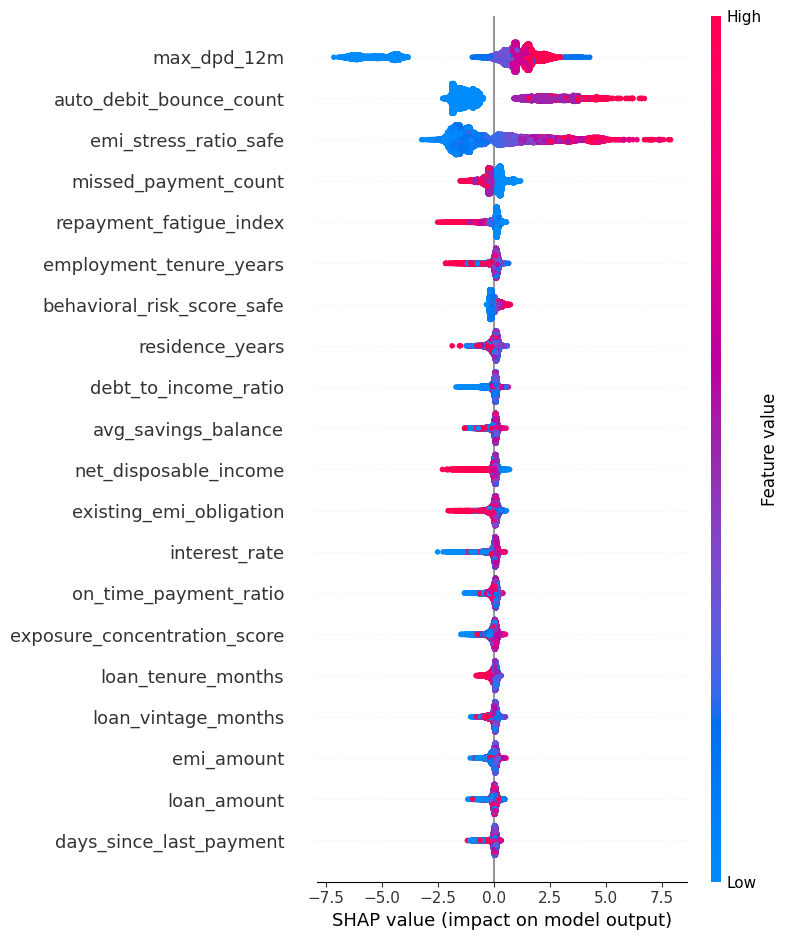

In [ ]:
print("\nComputing SHAP values (base model)...")
explainer = shap.TreeExplainer(base_clf)
sv = explainer.shap_values(X_test1_2)

if isinstance(sv, list):
    shap_vals = sv[1]
else:
    shap_vals = sv

shap.summary_plot(shap_vals, X_test1_2, show=True)


### Reason Code Demo (Individual Prediction Explanation)

This cell demonstrates how to generate 'reason codes' for a single customer's prediction using SHAP values, providing an interpretable explanation for why the model made a particular prediction:

*   **`i = 0`, `row = X_test2_2.iloc[[i]]`**: Selects the first customer's data (`row`) from `X_test2_2` for explanation.
*   **`sv1 = explainer.shap_values(row)`**: Computes SHAP values specifically for this single customer's row. Again, `sv1[1]` is selected for the positive class.
*   **`vals = sv1[0]`**: Extracts the SHAP values for the selected row.
*   **`cols = row.columns`**: Gets the column names corresponding to the features.
*   **`topk = np.argsort(np.abs(vals))[::-1][:5]`**: Finds the indices of the top 5 features that have the largest absolute SHAP values, meaning they had the most significant impact on the prediction (regardless of direction).
*   **Loop to Print Reasons**: Iterates through the top 5 features and prints:
    *   The feature name (`col`).
    *   The customer's value for that feature (`v`).
    *   The SHAP value (`impact`), indicating the magnitude of its influence.
    *   The `direction` of impact ('↑ risk' if SHAP > 0, '↓ risk' if SHAP < 0), explaining whether the feature's value increased or decreased the predicted risk for this customer).

This output provides a clear, actionable explanation for individual predictions, which is vital for trustworthiness and decision-making.

In [ ]:
print("\nReason code demo (1 customer from File02)...")

i = 0
row = X_test2_2.iloc[[i]]

sv1 = explainer.shap_values(row)
if isinstance(sv1, list):
    sv1 = sv1[1]

vals = sv1[0]
cols = row.columns
topk = np.argsort(np.abs(vals))[::-1][:5]

print("Top reasons:")
for j in topk:
    col = cols[j]
    v = row.iloc[0][col]
    impact = vals[j]
    direction = "↑ risk" if impact > 0 else "↓ risk"
    print(f"{col} = {v} | SHAP={impact:.4f} | {direction}")



Reason code demo (1 customer from File02)...
Top reasons:
auto_debit_bounce_count = 1 | SHAP=2.8890 | ↑ risk
max_dpd_12m = 60 | SHAP=1.2859 | ↑ risk
emi_stress_ratio_safe = 0.25485248712367475 | SHAP=-0.9827 | ↓ risk
missed_payment_count = 1 | SHAP=-0.7147 | ↓ risk
existing_emi_obligation = 33286.16 | SHAP=0.2091 | ↑ risk


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
